In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal,stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

data_base_name = "p"

In [2]:
def _acf(series, lags=20):

    acf_values = acf(series, nlags=lags)

    n = len(acf_values) * 10 
    conf_level = 1.96 / np.sqrt(n)

    significant_lags = []
    for i, acf_val in enumerate(acf_values[1:]):
        if abs(acf_val) > conf_level:
            significant_lags.append(i+1)

    return conf_level, acf_values, significant_lags   

In [3]:
   
data_filename = f"data\{data_base_name}.csv"
print(f'read {data_filename}')

columns = ['_time','pressure_1','pressure_2','temperature_1','temperature_2']

frame = pd.read_csv(data_filename, skiprows=[0,1,2], usecols=columns)
frame['_time'] = pd.to_datetime(frame['_time'], format="ISO8601")

series_name = "pressure_2"
   
times = frame["_time"]
series = frame[series_name]

print(frame.shape)

read data\p.csv
(2880, 5)


In [4]:
lags = 50
conf_level, acf_values, significant_lags = _acf(series, lags=lags)

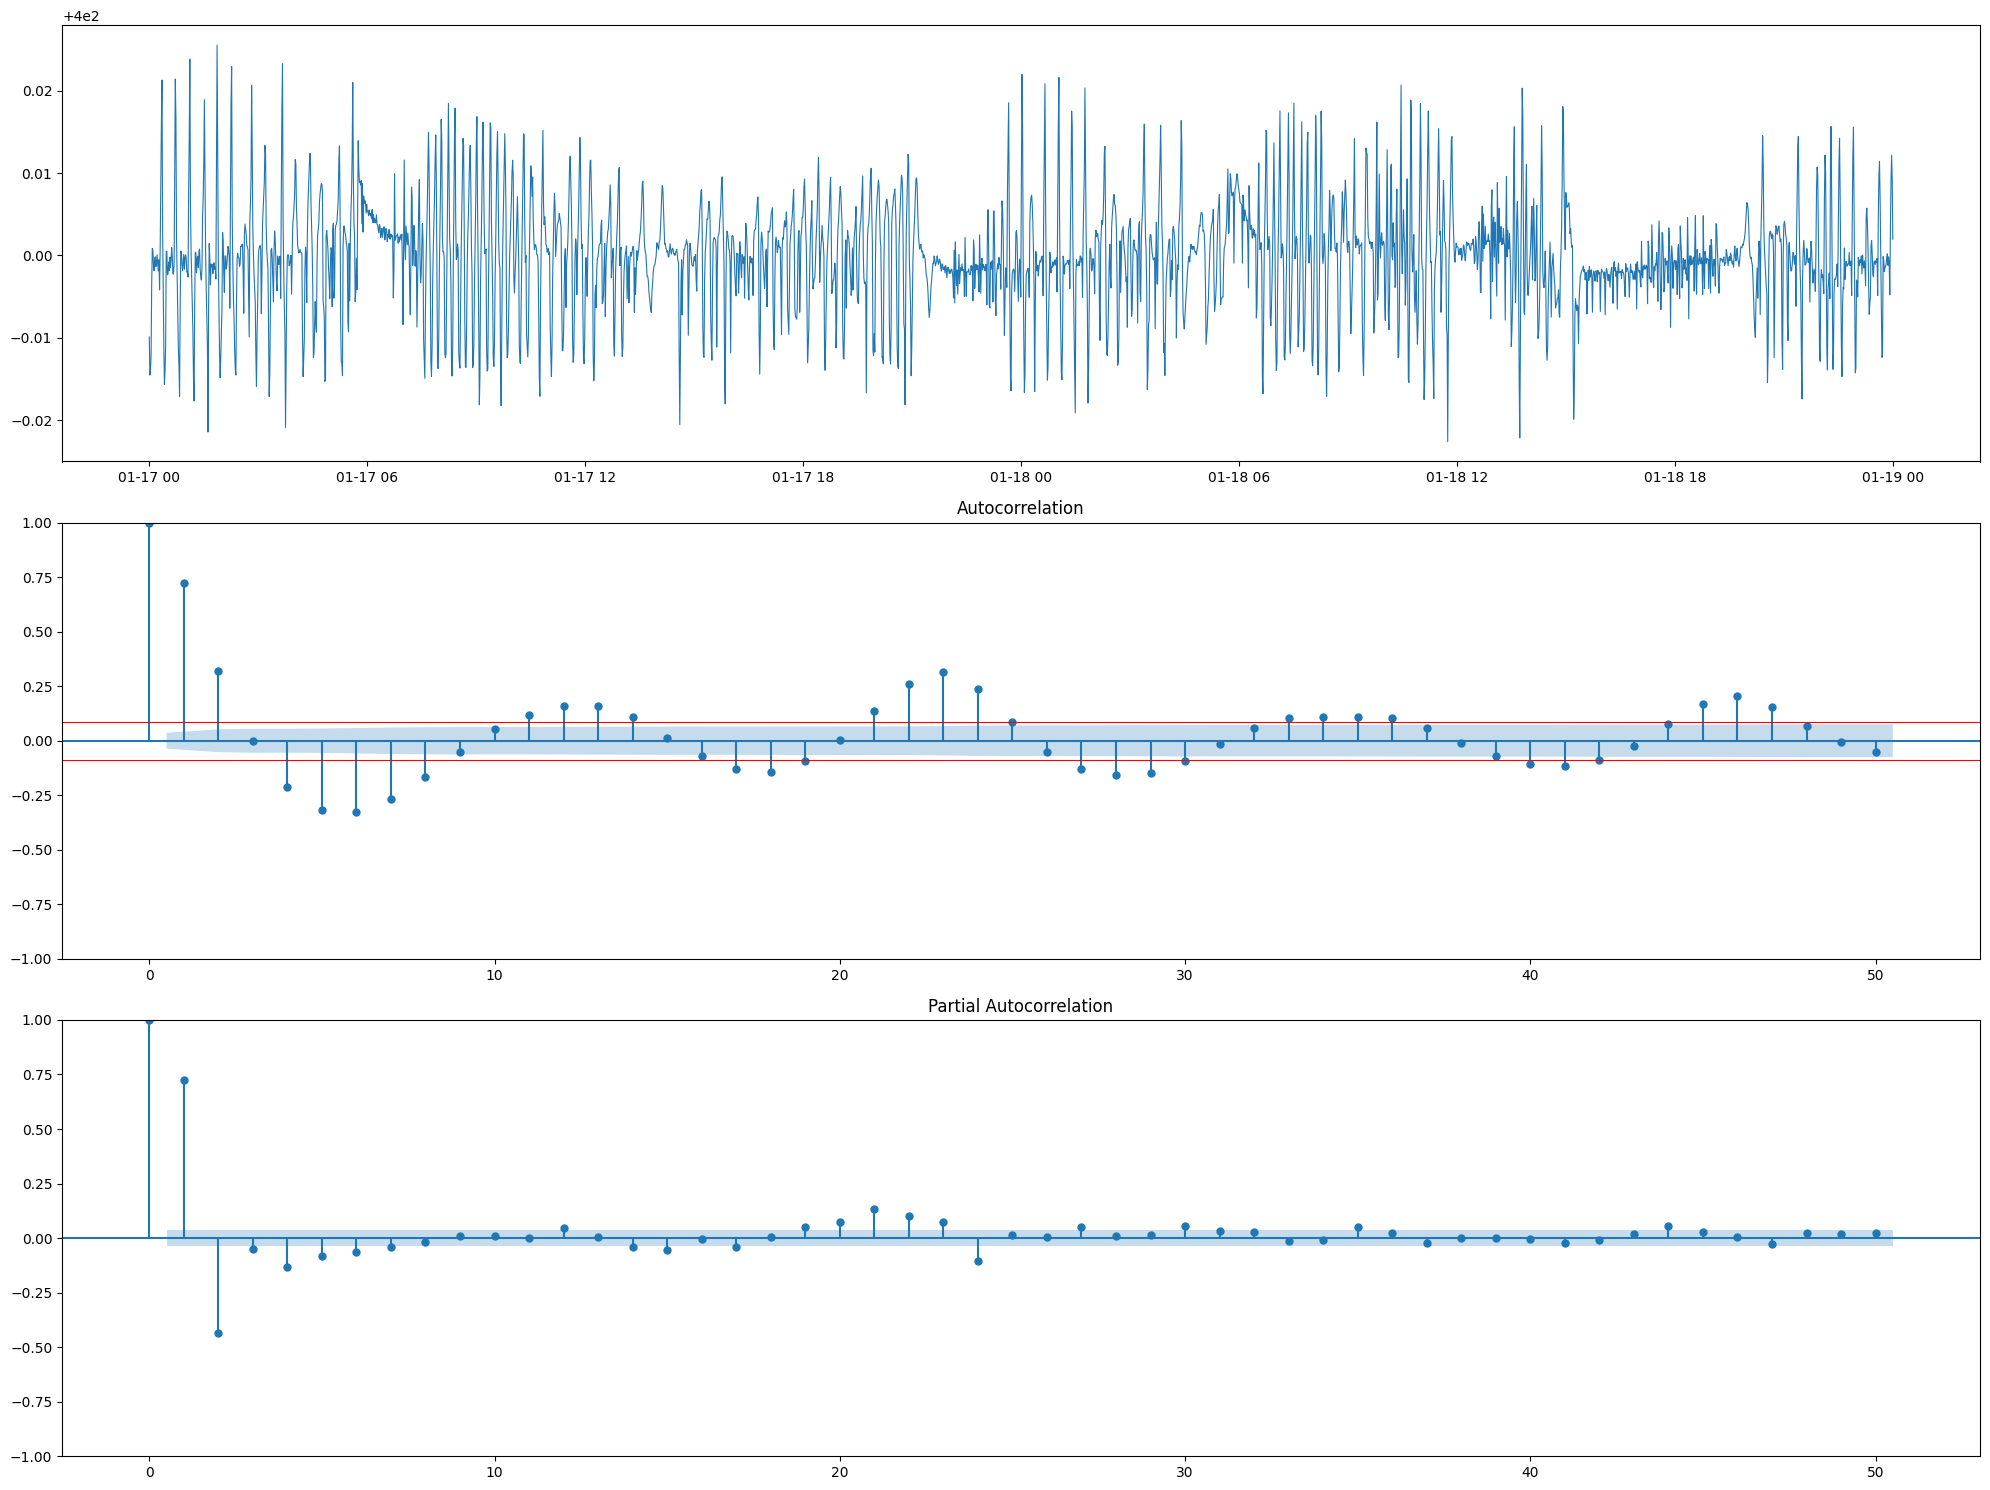

In [5]:
nrows = 3
fig, ax = plt.subplots(nrows,1,figsize=(20, nrows * 5))

ax[0].plot(frame["_time"], series, '-', lw=0.8)
plot_acf(series, lags=lags, ax=ax[1])
plot_pacf(series, lags=lags, ax=ax[2])

ax[1].axhline(y=conf_level, lw=0.8, c='r')
ax[1].axhline(y=-conf_level, lw=0.8, c='r')

plt.tight_layout()
plt.show()

In [6]:
def _trend(series, window=50):    
    moving_avg = pd.Series(series).rolling(window=window, center=True).mean()
    return moving_avg.values

def _seasonality(series, sampling_rate=100):
    
    # periodic patterns
    n = len(series)
    fft_vals = np.fft.fft(series)
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    
    # dominant frequencies
    magnitude = np.abs(fft_vals[:n//2])
    dominant_freq_idx = np.argsort(magnitude[1:])[-3:] + 1
    dominant_freqs = freqs[dominant_freq_idx]
    
    return freqs[:n//2], magnitude, dominant_freqs

def _peaks(series, height_threshold=1.5, distance=50):    
    peaks, properties = signal.find_peaks(
        series, 
        height=height_threshold,
        distance=distance,
        prominence=0.5
    )
    return peaks, properties

def _anomalies_zscore(series, threshold=3):            
    z_scores = np.abs(stats.zscore(series))
    anomalies = np.where(z_scores > threshold)[0]
    return anomalies, z_scores

def _change_points(series, window=50):    

    rolling_std = pd.Series(series).rolling(window=window).std().values
    change_points = signal.find_peaks(rolling_std, height=np.mean(rolling_std)*1.2)[0]
    return change_points, rolling_std

def _seasonality2(series, period=50):     
     return seasonal_decompose(series, model='additive', period=period)

In [19]:
print(f"--- time series with  {len(series)} data points")

win = int(np.sqrt(len(series)))

trend = _trend(series, window=win)
trend2 = _seasonality2(series)

freqs, magnitude, dominant_freqs = _seasonality(series)
peaks, peak_props = _peaks(series, distance=win)
anomalies, z_scores = _anomalies_zscore(series)
change_points, rolling_std = _change_points(series)

N = len(z_scores)
zz = [np.where((z_scores >=-1) & (z_scores <= 1))[0].shape[0] / N,
      np.where((z_scores >=-2) & (z_scores <= 2))[0].shape[0] / N,
      np.where((z_scores >=-3) & (z_scores <= 3))[0].shape[0] / N]

zz

--- time series with  2880 data points


[0.7409722222222223, 0.9288194444444444, 0.9930555555555556]

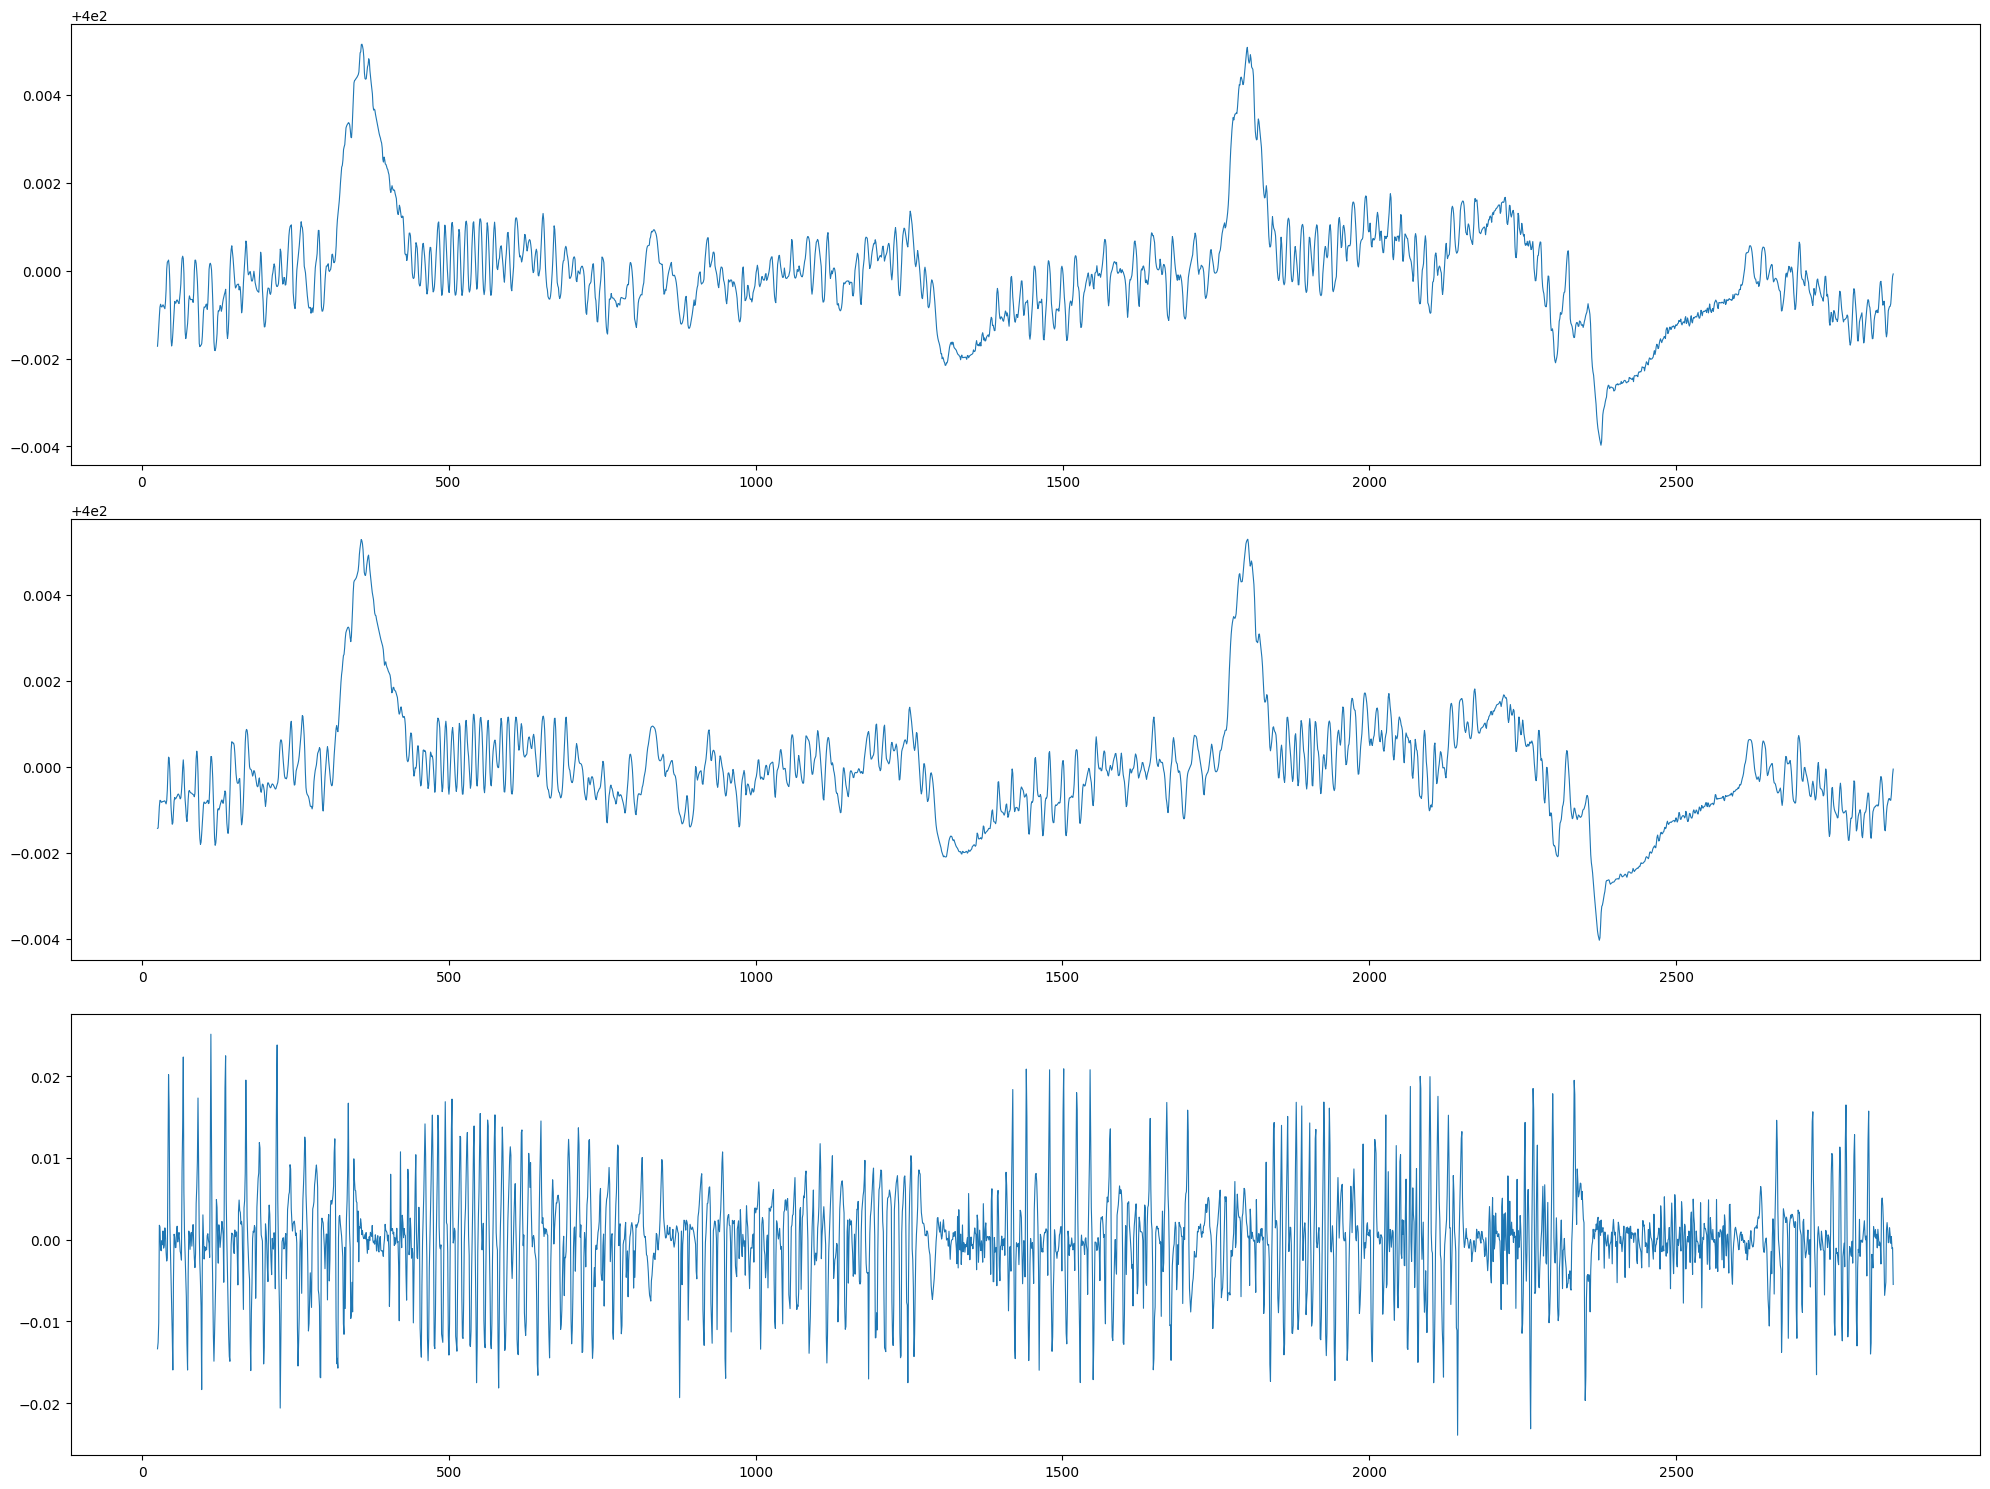

In [13]:

nrows = 3
fig, ax = plt.subplots(nrows,1,figsize=(20, nrows * 5))

ax[0].plot(trend, '-', lw=0.8)
ax[1].plot(trend2.trend, '-', lw=0.8)

ax[2].plot(trend2.resid, '-', lw=0.8)

plt.tight_layout()
plt.show()

In [15]:
print(f"trend       {'yes' if not np.all(np.isnan(trend)) else 'no'}")
print(f"frequencies {dominant_freqs[:3]} Hz")
print(f"peaks       {len(peaks)} @ {peaks[:5]}")
print(f"anomalies   {len(anomalies)}")
print(f"changes     {len(change_points)}")

#detected_true_spikes = set(true_spikes) & set(peaks)
#print(f"\n✓ Richtig erkannte Spikes: {len(detected_true_spikes)}/{len(true_spikes)}")
    

trend       yes
frequencies [8.64583333 8.88888889 8.4375    ] Hz
peaks       0 @ []
anomalies   20
changes     0


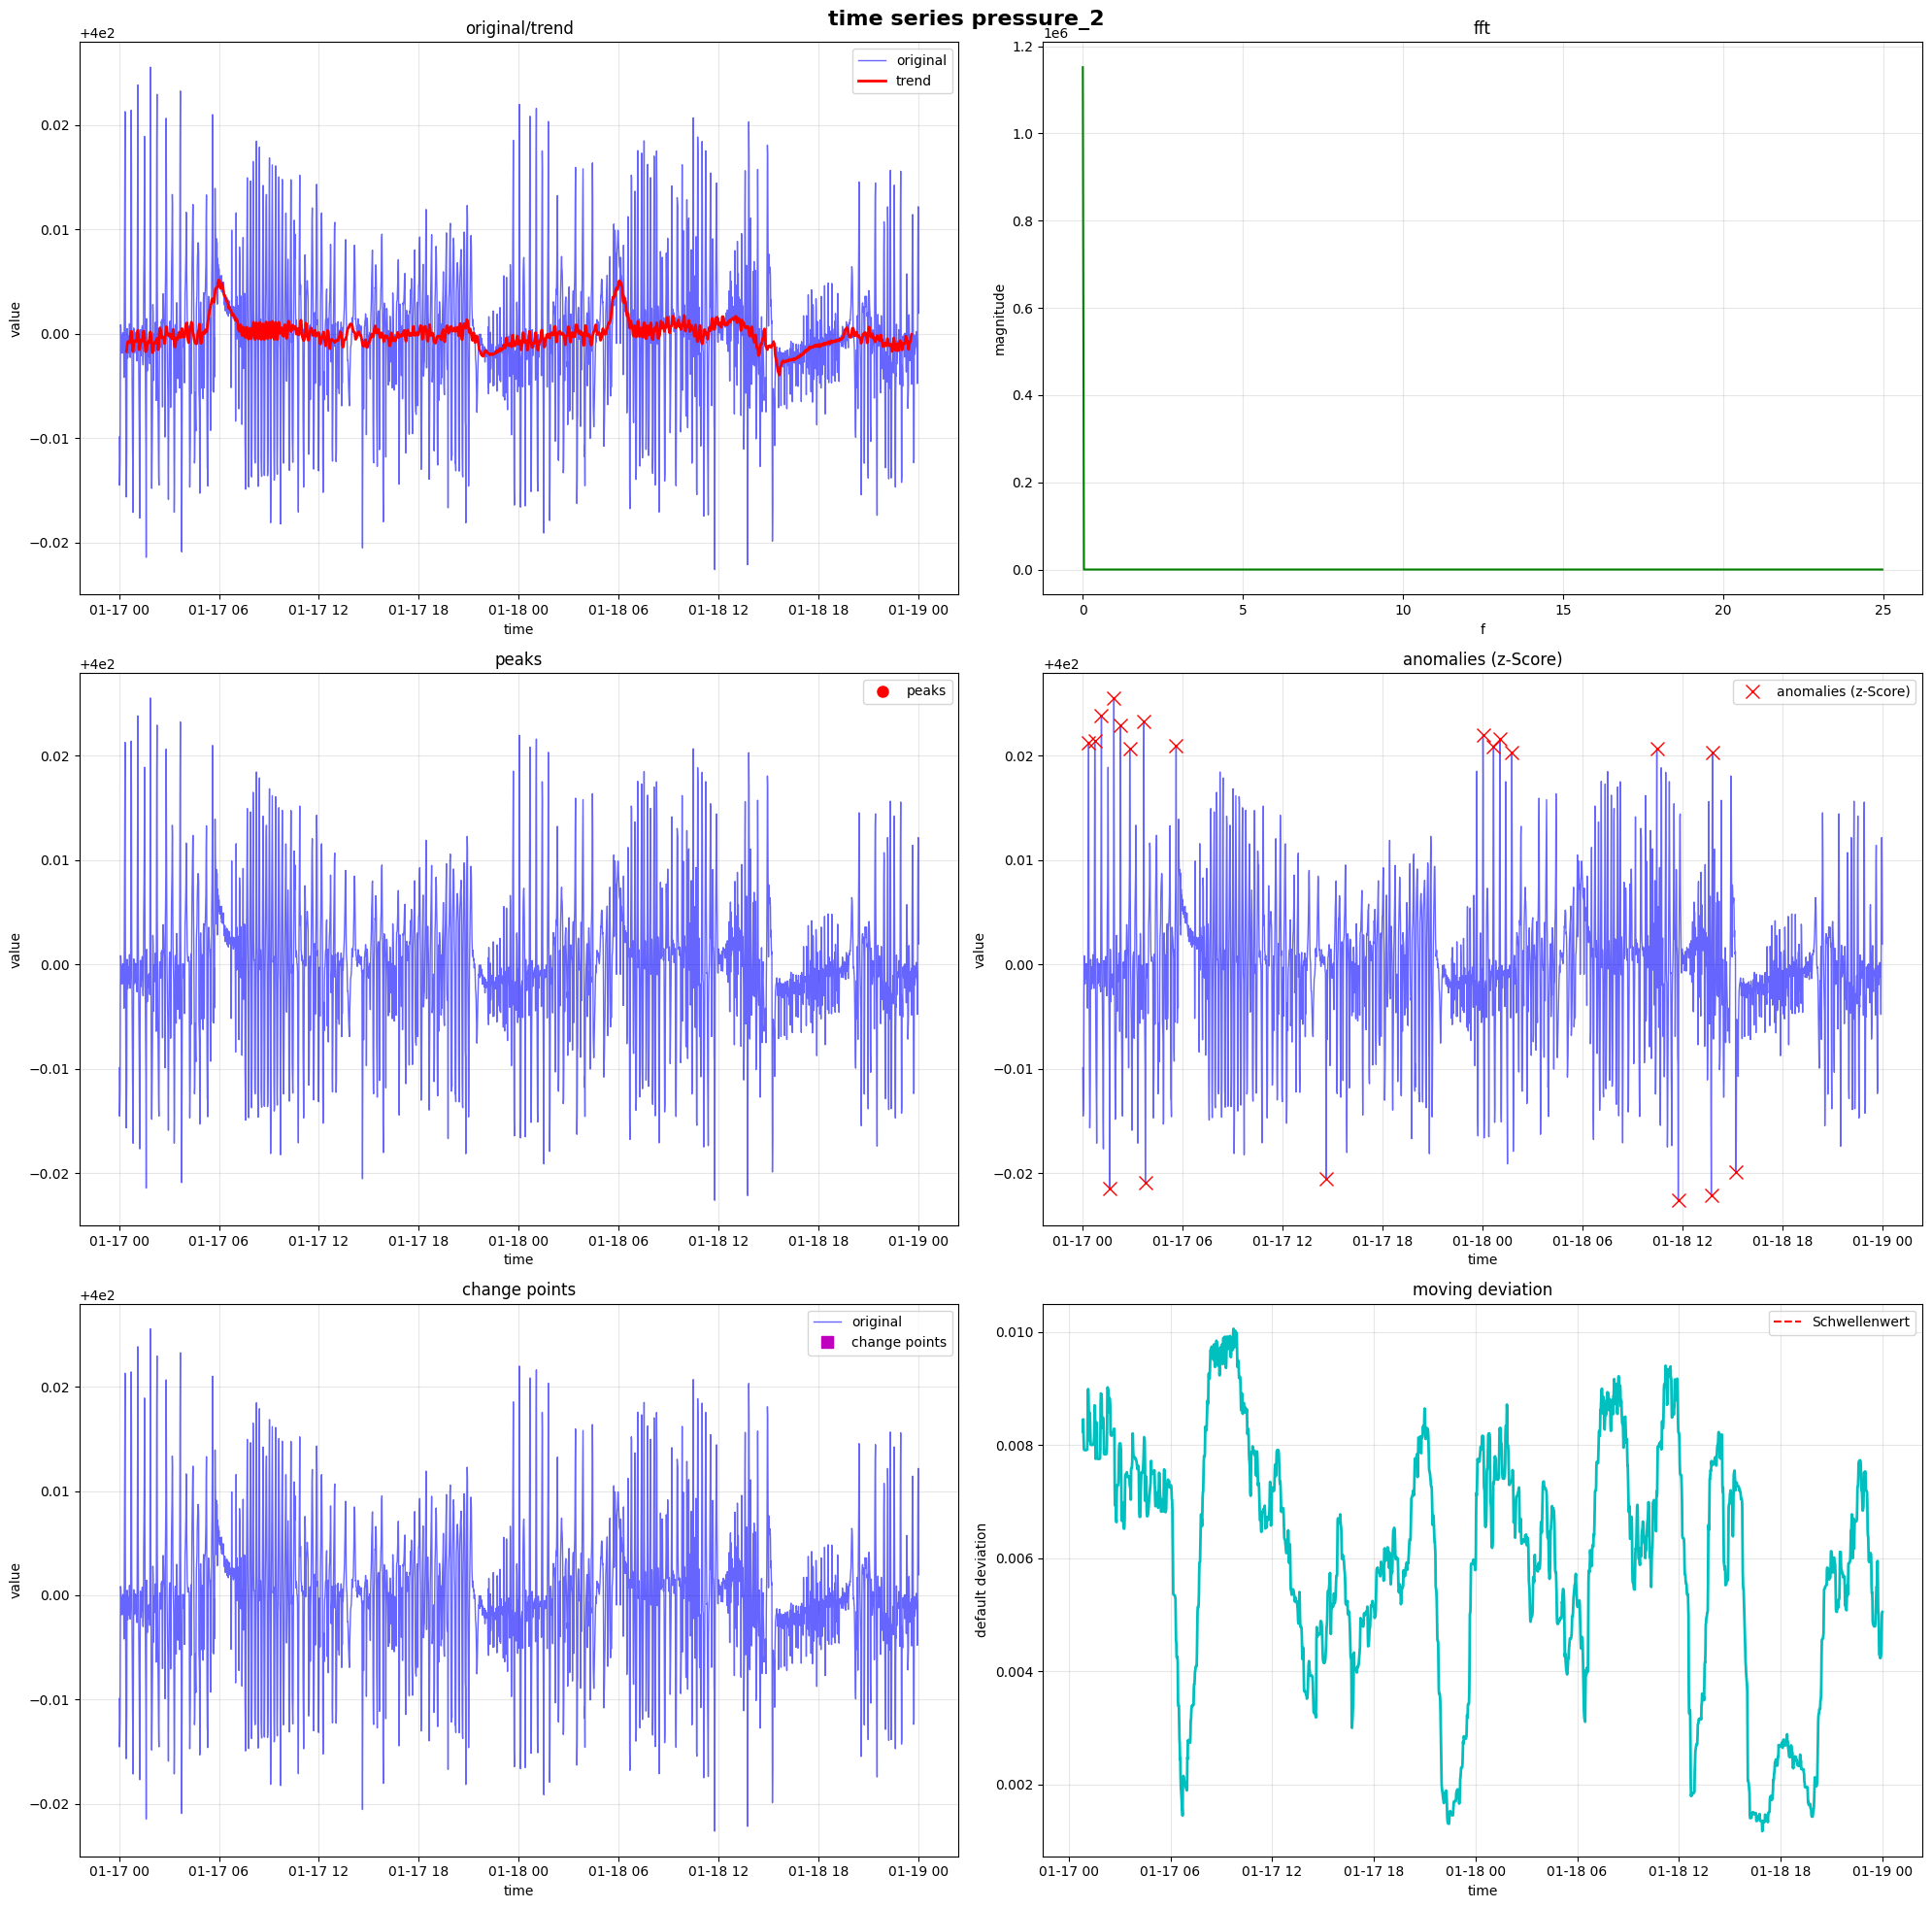

In [17]:

t, ts = times, series

fig, ax = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle(f'time series {series_name}', fontsize=16, fontweight='bold')
# 
ax[0,0].plot(t, ts, 'b-', alpha=0.6, label='original', linewidth=1)
ax[0,0].plot(t, trend, 'r-', linewidth=2, label='trend')
ax[0,0].set_title('original/trend')
ax[0,0].set_xlabel('time')
ax[0,0].set_ylabel('value')
ax[0,0].legend()
ax[0,0].grid(True, alpha=0.3)

ax[0,1].plot(freqs[:len(freqs)//2], magnitude[:len(magnitude)//2], 'g-')
ax[0,1].set_title('fft')
ax[0,1].set_xlabel('f')
ax[0,1].set_ylabel('magnitude')
ax[0,1].grid(True, alpha=0.3)

ax[1,0].plot(t, ts, 'b-', alpha=0.6, linewidth=1)
ax[1,0].plot(t[peaks], ts[peaks], 'ro', markersize=8, label='peaks')
ax[1,0].set_title('peaks')
ax[1,0].set_xlabel('time')
ax[1,0].set_ylabel('value')
ax[1,0].legend()
ax[1,0].grid(True, alpha=0.3)

# anomalies
ax[1,1].plot(t, ts, 'b-', alpha=0.6, linewidth=1)
ax[1,1].plot(t[anomalies], ts[anomalies], 'rx', markersize=10, label='anomalies (z-Score)')
ax[1,1].set_title('anomalies (z-Score)')
ax[1,1].set_xlabel('time')
ax[1,1].set_ylabel('value')
ax[1,1].legend()
ax[1,1].grid(True, alpha=0.3)

# change points
ax[2,0].plot(t, ts, 'b-', alpha=0.6, linewidth=1, label='original')
ax[2,0].plot(t[change_points], ts[change_points], 'ms', markersize=8, label='change points')
ax[2,0].set_title('change points')
ax[2,0].set_xlabel('time')
ax[2,0].set_ylabel('value')
ax[2,0].legend()
ax[2,0].grid(True, alpha=0.3)

ax[2,1].plot(t, rolling_std, 'c-', linewidth=2)
ax[2,1].axhline(y=np.mean(rolling_std)*1.2, color='r', linestyle='--', 
                    label='Schwellenwert')
ax[2,1].set_title('moving deviation')
ax[2,1].set_xlabel('time')
ax[2,1].set_ylabel('default deviation')
ax[2,1].legend()
ax[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

series_list = [series]
n_series = len(series_list)

scaler = TimeSeriesScalerMeanVariance()
series_scaled = scaler.fit_transform(np.array(series_list).reshape(n_series, -1, 1))

# DTW based clustering
model = TimeSeriesKMeans(n_clusters=2, metric="dtw", verbose=False, random_state=42)
labels = model.fit_predict(series_scaled)
    
labels

array([0])